In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split


In [2]:
data_url='https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(data_url,'.')

Using downloaded and verified file: ./cifar10.tgz


In [3]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
data_dir='./data/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+'/train')
print(classes)

['test', 'train']
['automobile', 'airplane', 'truck', 'ship', 'bird', 'horse', 'deer', 'frog', 'cat', 'dog']


In [4]:
airplane_files=os.listdir(data_dir+ '/train/airplane')
print('no of training examples for airplanes', len(airplane_files))
print(airplane_files[:5])

no of training examples for airplanes 5000
['1583.png', '0102.png', '1174.png', '4663.png', '2233.png']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
dataset=ImageFolder(data_dir+ '/train',transform=ToTensor())

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

In [8]:
img, label=dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [9]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
import matplotlib.pyplot as plt

In [11]:
def show_img(img, label):
  print('label: ',dataset.classes[label],"("+ str(label)+")")
  plt.imshow(img.permute(1,2,0))  #takes the channel and flips it

label:  airplane (0)


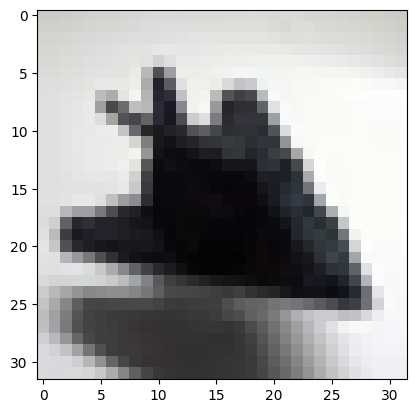

In [12]:
show_img(*dataset[0])  # * is used to use img, and label together

label:  airplane (0)


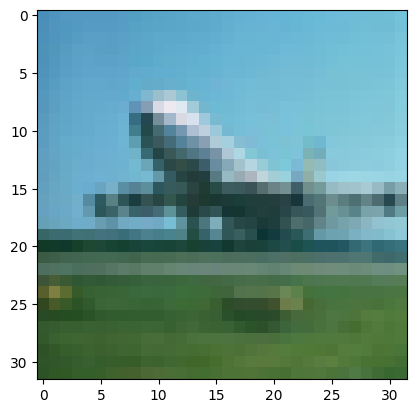

In [13]:
show_img(*dataset[100])

In [14]:
random_seed=42
torch.manual_seed(random_seed)

In [15]:
val_size=5000
train_size=len(dataset)-val_size

train_ds, val_ds=random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [16]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [17]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl=DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax=plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

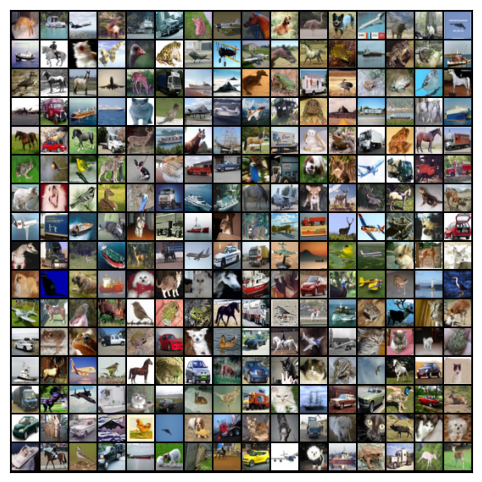

In [19]:
show_batch(val_dl)

In [20]:
def apply_kernel(image, kernel):
  ri,ci = image.shape
  rk, ck= kernel.shape
  ro, co= ri-rk+1, ci-ck+1
  output=torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
      output[i,j]=torch.sum(image[i:i+rk, j:j+ck]*kernel)
  return output

In [21]:
sample_image=torch.tensor([
    [3,3,2,1,0],
    [0,0,1,3,1],
    [3,1,2,2,3],
    [2,0,0,2,2],
    [2,0,0,0,1]
], dtype=torch.float32)

sample_kernel=torch.tensor([
    [0,1,2],
    [2,2,0],
    [0,1,2]
], dtype=torch.float32)
apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
conv= nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1) #convert from 3 channel to 8 channel
# padding means we have 1 pixel of padding arounf the input
#this is done so we get the output the same size as input

In [24]:
pool=nn.MaxPool2d(2,2)
# reduces the dimensions

In [25]:
for images,labels in train_dl:
  print(images.shape)
  out=conv(images)
  out=pool(out)
  print('output.shape:' ,out.shape)
  break

torch.Size([128, 3, 32, 32])
output.shape: torch.Size([128, 8, 16, 16])


In [26]:
simple_model=nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [27]:
conv.weight

Parameter containing:
tensor([[[[-0.0568,  0.0204,  0.0095],
          [ 0.0666,  0.0400, -0.0671],
          [ 0.1560,  0.0757,  0.0781]],

         [[-0.1201, -0.0989,  0.0508],
          [ 0.1701,  0.0643,  0.1109],
          [-0.0033,  0.1575, -0.1299]],

         [[ 0.1855,  0.0587, -0.1072],
          [ 0.1864,  0.0403,  0.0994],
          [ 0.1686, -0.1169, -0.1352]]],


        [[[ 0.1361, -0.0403, -0.1402],
          [ 0.0297, -0.1356,  0.1519],
          [-0.0803, -0.1281,  0.0853]],

         [[ 0.1624,  0.0438,  0.1575],
          [-0.0313, -0.1402,  0.0774],
          [-0.0561, -0.0485, -0.1848]],

         [[ 0.0140, -0.0902, -0.0311],
          [ 0.0133, -0.1269,  0.1138],
          [ 0.1813, -0.0442, -0.1534]]],


        [[[ 0.0476, -0.0057, -0.1522],
          [ 0.0428,  0.1135,  0.0449],
          [ 0.0477,  0.1006,  0.1239]],

         [[-0.0219,  0.0941, -0.1691],
          [ 0.1094,  0.0677, -0.1759],
          [ 0.0430, -0.1489,  0.1766]],

         [[-0.1772, -0

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [30]:
model=Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [31]:
for images, labels in train_dl:
  print(images.shape)
  out=model(images)
  print(out.shape)
  print('out[0]', out[0])
  break

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])
out[0] tensor([-0.0153,  0.0196, -0.0060,  0.0209, -0.0394, -0.0300,  0.0173,  0.0133,
         0.0156, -0.0233], grad_fn=<SelectBackward0>)


In [32]:
torch.cuda.is_available()

True

In [33]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  # Move tensors to chosen device
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  # wrap a dataloader to move data to a device
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    # yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # no of batches
    return len(self.dl)

In [34]:
device=get_default_device()
device

device(type='cuda')

In [64]:
# We can now wrap our training and validation data loaders using
# DeviceDataLoader for automatically transferring batches of data to the GPU and
# use to_device to move our model to the GPU

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [67]:
# Training the model

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
model=to_device(Cifar10CnnModel(), device)

In [38]:
evaluate(model, val_dl)

{'val_loss': 2.303417205810547, 'val_acc': 0.0963350161910057}

In [39]:
num_epochs=10
opt_func=torch.optim.Adam
lr=0.001

In [40]:
history=fit(num_epochs, lr,model, train_dl, val_dl, opt_func )

Epoch [0], train_loss: 1.8899, val_loss: 1.5350, val_acc: 0.4300
Epoch [1], train_loss: 1.3883, val_loss: 1.3327, val_acc: 0.5185
Epoch [2], train_loss: 1.1288, val_loss: 1.1183, val_acc: 0.6020
Epoch [3], train_loss: 0.9360, val_loss: 0.9071, val_acc: 0.6781
Epoch [4], train_loss: 0.7767, val_loss: 0.8328, val_acc: 0.7161
Epoch [5], train_loss: 0.6784, val_loss: 0.8080, val_acc: 0.7265
Epoch [6], train_loss: 0.5847, val_loss: 0.7528, val_acc: 0.7464
Epoch [7], train_loss: 0.4970, val_loss: 0.7152, val_acc: 0.7582
Epoch [8], train_loss: 0.4242, val_loss: 0.7676, val_acc: 0.7452
Epoch [9], train_loss: 0.3587, val_loss: 0.8344, val_acc: 0.7473


In [41]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs no of epochs')

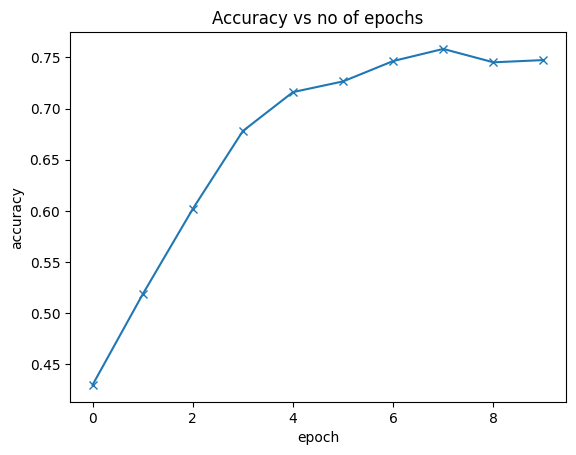

In [42]:
plot_accuracies(history)

In [43]:
def plot_losses(history):
    train_losses=[x.get('train_loss') for x in history]
    val_losses=[x['val_loss'] for x in history]
    plt.plot(train_losses,'-bx')
    plt.plot(val_losses,'-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs no of epochs')

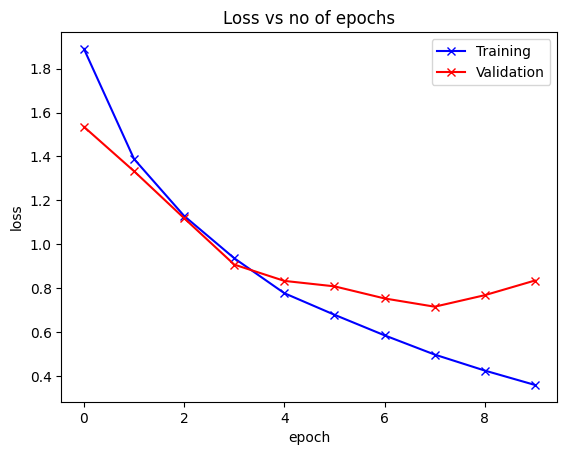

In [44]:
plot_losses(history)

In [45]:
# Overfitting is happening as our validation loss is increasing after
# training for some epochs

How to avoid overfitting?\
gather and generate more training data or add noise to it\
using regularization techniques like batch normalization and dropout\
early stopping of model's training, when validation loss starts increasing

Testing with individual images

In [46]:
test_dataset=ImageFolder(data_dir+'/test', transform=ToTensor())

In [53]:
def predict_image(img, model):
    # convert to a batch of 1
    xb=to_device(img.unsqueeze(0), device)
    # get preditions
    yb=model(xb)
    # pick the index with highest probabilty
    _,preds=torch.max(yb,dim=1)
    # return the class label
    return dataset.classes[preds[0].item()]

label: airplane prediction: airplane


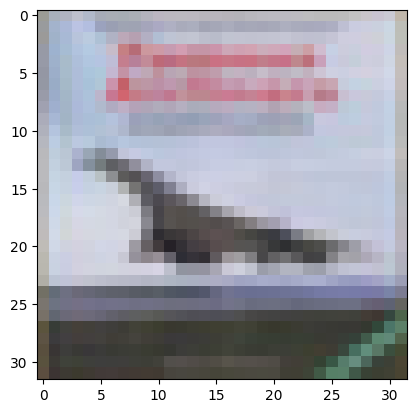

In [54]:
img, label=test_dataset[0]
plt.imshow(img.permute(1,2,0))
print('label:', dataset.classes[label], 'prediction:', predict_image(img, model))

label: automobile prediction: automobile


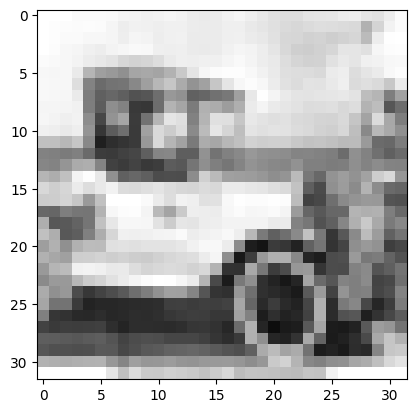

In [55]:
img, label=test_dataset[1002]
plt.imshow(img.permute(1,2,0))
print('label:', dataset.classes[label], 'prediction:', predict_image(img, model))

label: frog prediction: frog


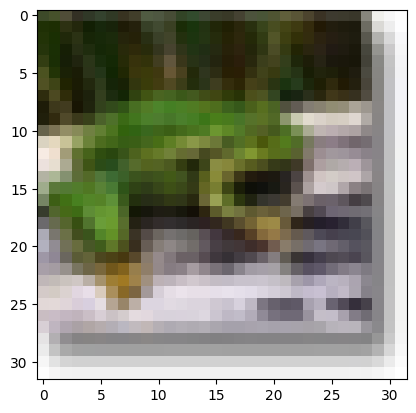

In [58]:
img, label=test_dataset[6210]
plt.imshow(img.permute(1,2,0))
print('label:', dataset.classes[label], 'prediction:', predict_image(img, model))

label: ship prediction: ship


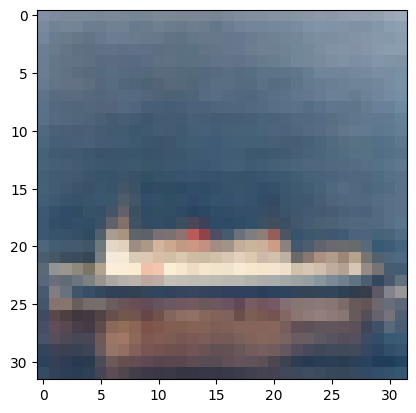

In [60]:
img, label=test_dataset[8510]
plt.imshow(img.permute(1,2,0))
print('label:', dataset.classes[label], 'prediction:', predict_image(img, model))

In [61]:
test_loader=DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result=evaluate(model, test_loader)
result

{'val_loss': 0.811484158039093, 'val_acc': 0.7544921636581421}

In [62]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [63]:
# redefine the saved model
model2=to_device(Cifar10CnnModel(), device)

In [64]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<ipython-input-64-b852cd57b3dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('cifar10-cnn.pth'))


<All keys matched successfully>

In [65]:
evaluate(model2, test_loader)

{'val_loss': 0.811484158039093, 'val_acc': 0.7544921636581421}

In [67]:
!pip install jovian

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.7 MB/s eta 0:00:00
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6478 sha256=87f5640150eef092177dfe95deb8ed739a8489378f06d5439a2e8bb7932ebb94
  Stored in directory: /root/.cache/pip/wheels/ed/08/9e/f0a977dfe55051a07e21af89200125d65f1efa60cbac61ed88
Successfully built uuid
